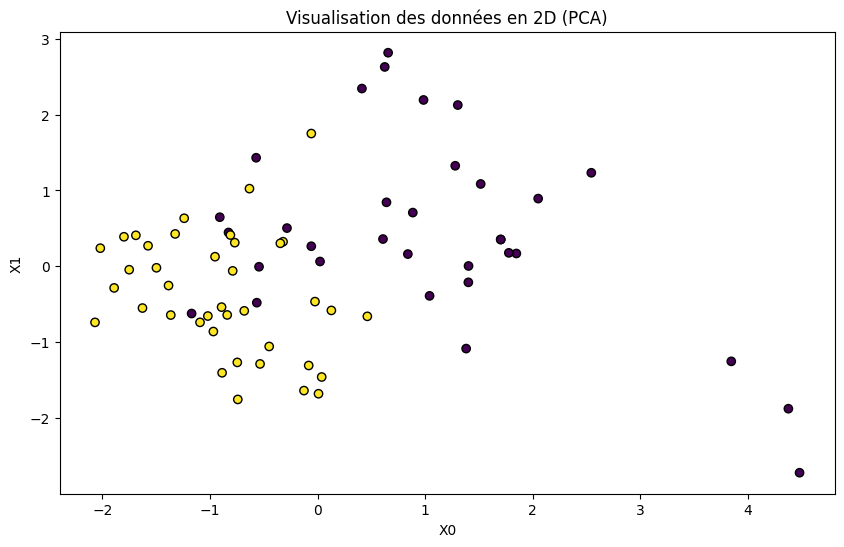

In [8]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import tkinter as tk
from tkinter import messagebox

# ==============================
# 1. Chargement et préparation des données
# ==============================
file_path = "Cryotherapy.csv"  # Assure-toi que le fichier est dans le même dossier
data = pd.read_csv(file_path, decimal=',')

X = data.drop('Result_of_Treatment', axis=1)
y = data['Result_of_Treatment']

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# PCA pour visualisation en 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k')
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Visualisation des données en 2D (PCA)')
plt.show()


In [9]:
# ==============================
# 2. Modèle linéaire (SGD) pour comparaison
# ==============================
clf = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
sgd_acc = clf.score(X_test, y_test)
print(f"Accuracy du modèle linéaire : {sgd_acc:.2f}")

Accuracy du modèle linéaire : 0.83


In [10]:
# ==============================
# 3. Réseau de Neurones Profond (DNN)
# ==============================
model = Sequential([
    Dense(16, activation='relu', input_dim=X.shape[1]),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping pour éviter le sur-apprentissage
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=300, batch_size=8, verbose=0,
                    callbacks=[early_stop])

# Évaluation du DNN
dnn_loss, dnn_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy du réseau de neurones : {dnn_acc:.2f}")


Accuracy du réseau de neurones : 0.83


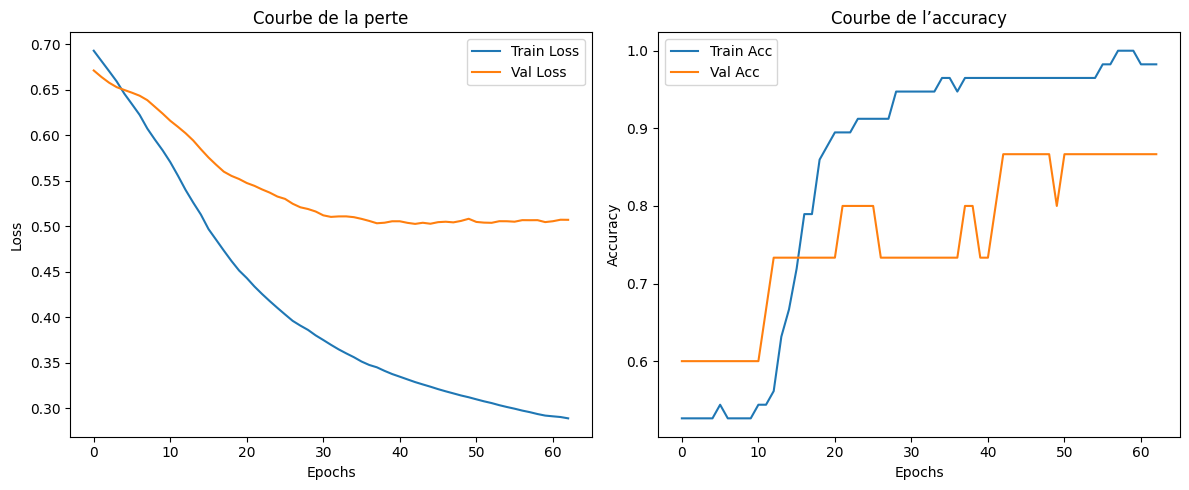

In [11]:

# ==============================
# 4. Courbes d'apprentissage
# ==============================


plt.figure(figsize=(12, 5))

# Courbe Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Courbe de la perte')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Courbe Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Courbe de l’accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1250/1250 [==============================] - 2s 2ms/step


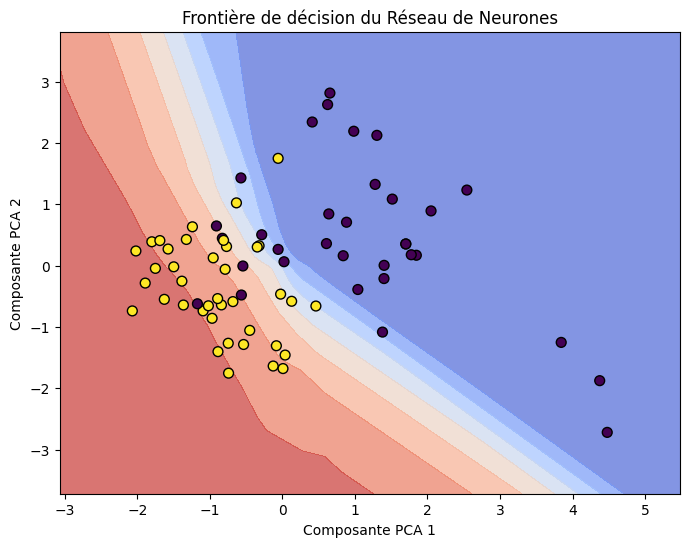

In [12]:
# ==============================
# 5. Frontière de décision du DNN
# ==============================
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Transformer la grille en espace original
grid = np.c_[xx.ravel(), yy.ravel()]
grid_original = pca.inverse_transform(grid)
Z = model.predict(grid_original)
Z = Z.reshape(xx.shape)

# Tracer la frontière
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.7)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('Frontière de décision du Réseau de Neurones')
plt.xlabel('Composante PCA 1')
plt.ylabel('Composante PCA 2')
plt.show()

In [16]:
# Résumé des résultats
# ==============================
print("\nRésumé :")
print(f"Modèle Linéaire (SGD) : {sgd_acc*100:.2f}%")
print(f"Réseau de Neurones : {dnn_acc*100:.2f}%")


Résumé :
Modèle Linéaire (SGD) : 83.33%
Réseau de Neurones : 83.33%


In [15]:
# ==============================
# 6. Interface graphique pour prédiction
# ==============================
def predict():
    try:
        # Récupération des valeurs saisies
        sex = float(entry_sex.get())
        age = float(entry_age.get())
        time = float(entry_time.get())
        number = float(entry_number.get())
        wart_type = float(entry_type.get())
        area = float(entry_area.get())

        # Préparation et normalisation
        input_data = np.array([[sex, age, time, number, wart_type, area]])
        input_scaled = scaler.transform(input_data)

        # Prédiction
        prediction = model.predict(input_scaled)[0][0]
        result = "✅ Traitement Réussi" if prediction >= 0.5 else "❌ Traitement Échoué"

        # Affichage dans la même fenêtre
        result_label.config(text=f"Résultat : {result}\nProbabilité : {prediction:.2f}")
    except ValueError:
        result_label.config(text="Erreur : valeurs invalides !")

def clear_fields():
    # Efface toutes les entrées et le résultat
    for entry in entries:
        entry.delete(0, tk.END)
    result_label.config(text="")

# Interface Tkinter
root = tk.Tk()
root.title("Prédiction Cryothérapie")

# Création des champs
labels = ["Sexe (1=Homme, 2=Femme)", "Âge", "Durée (Time)", "Nombre de verrues", "Type", "Zone (Area)"]
entries = []

for i, label in enumerate(labels):
    tk.Label(root, text=label).grid(row=i, column=0, padx=10, pady=5, sticky="w")
    entry = tk.Entry(root)
    entry.grid(row=i, column=1, padx=10, pady=5)
    entries.append(entry)

entry_sex, entry_age, entry_time, entry_number, entry_type, entry_area = entries

# Boutons
tk.Button(root, text="Prédire", command=predict, bg="green", fg="white").grid(row=6, column=0, pady=10)
tk.Button(root, text="Effacer", command=clear_fields, bg="red", fg="white").grid(row=6, column=1, pady=10)

# Zone d'affichage du résultat
result_label = tk.Label(root, text="", font=("Arial", 12), fg="blue")
result_label.grid(row=7, column=0, columnspan=2, pady=10)

root.mainloop()


1/1 [==============================] - 0s 33ms/step


c:\Users\lass.DESKTOP-SAQTCJE\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
